### Что необходимо сделать: реализовать один из алгоритмов машинного обучения, являющегося композицией алгоритмов.
Москаленко Андрей

### Вариант 21

In [1]:
import re
import numpy as np
import cupy as cp
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn.metrics

In [2]:
import tqdm.notebook
from joblib import Parallel, delayed

In [3]:
lines = []
with open('./reg.train.txt', 'r') as f:
    lines = f.readlines()
lines = list(map(lambda x: re.split(':| ', x.strip()), lines))
X_train = np.full((7200, 245), 0.0)
y_train = np.zeros((7200))
for i in range(len(lines)):
    y_train[i] = float(lines[i][0])
    for j in range(1, len(lines[i]), 2):
        X_train[i, int(lines[i][j]) - 1] = float(lines[i][j + 1])
X_train = np.nan_to_num(X_train)

In [4]:
lines = []
with open('./reg.test.txt', 'r') as f:
    lines = f.readlines()
lines = list(map(lambda x: re.split(':| ', x.strip()), lines))
X_test = np.full((10050, 245), 0.0)
y_test = np.zeros((10050))
for i in range(len(lines)):
    y_test[i] = float(lines[i][0])
    for j in range(1, len(lines[i]), 2):
        X_test[i, int(lines[i][j]) - 1] = float(lines[i][j + 1])
X_test = np.nan_to_num(X_test)

In [5]:
path_index = -1

class Node:
    def __init__(self, x, y, idxs, min_leaf=5, depth=1, max_features=15):
        global path_index
        path_index += 1
        self.path_index = path_index
        self.depth=depth
        self.x = x
        self.y = y
        self.idxs = idxs
        self.y_idx = y[self.idxs]
        self.min_leaf = min_leaf
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.max_features = max_features
        self.find_varsplit()

    def find_varsplit(self):
        if self.depth != 0:
            while True:
                random_features = np.random.choice(list(range(self.col_count)), self.max_features)
                splits = Parallel(n_jobs=16)(delayed(self.find_better_split)(c) for c in random_features)
                splits = np.array(splits)
                best_id = np.argsort(splits[:, 0])[0]
                self.score = splits[best_id][0]
                if not self.is_leaf:
                    break
            self.split = splits[best_id][1]
            self.var_idx = int(splits[best_id][2])
            if self.is_leaf:
                return
            x = self.x[self.idxs, self.var_idx]
            lhs = np.nonzero(x <= self.split)[0]
            rhs = np.nonzero(x > self.split)[0]
            self.lhs = Node(self.x, self.y, self.idxs[lhs], self.min_leaf, self.depth - 1, self.max_features)
            self.rhs = Node(self.x, self.y, self.idxs[rhs], self.min_leaf, self.depth - 1, self.max_features)

    def find_better_split(self, var_idx):
        x = self.x[self.idxs, var_idx]
        best_score = 99999999999999
        best_split = 0
        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]
            if rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf: 
                continue
            curr_score = self.find_score(lhs, rhs)
            if curr_score < best_score:
                best_score = curr_score
                best_split = x[r]
        return [best_score, best_split, var_idx]

    def find_score(self, lhs, rhs):
        return ((self.y_idx[lhs] - self.y_idx[lhs].mean()) ** 2).sum() + \
               ((self.y_idx[rhs] - self.y_idx[rhs].mean()) ** 2).sum()

    @property
    def is_leaf(self): 
        return self.score == float('inf')
    
    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])
    def predict_row(self, xi):
        if self.is_leaf:
            return self.val
        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)

    def apply(self, x):
        return np.array([self.apply_row(xi) for xi in x])
    def apply_row(self, xi):
        if self.is_leaf:
            return self.path_index
        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.apply_row(xi)

In [6]:
class MyDecisionTreeRegressor:
    def __init__(self, min_samples_leaf=1, max_depth=1, max_features=15):
        global path_index
        path_index = -1
        self.min_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.max_features = max_features
    def fit(self, X, y):
        self.tree_ = Node(X, y, np.array(np.arange(len(y))), self.min_leaf, self.max_depth, self.max_features)
        self.tree_.node_count = 2 ** (self.max_depth + 1) - 1
        return self

    def apply(self, X):
        return self.tree_.apply(X)
    
    def predict(self, X):
        return self.tree_.predict(X)

### Hand-written gradient boosting

In [9]:
class GradBoost():
    def __init__(self, n_trees=128, lr=0.1, min_samples_leaf=1, max_depth=1, max_features=15):
        self.n_trees = n_trees
        self.lr = lr
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.max_features = max_features

    def fit(self,X,y):
        y = y.reshape(-1, 1)
        self.X=X
        self.y=y
        self.boosted_models = []

        ensemble_pred = np.ones(len(y)) * 0
        
        for i in range(self.n_trees):
            model = MyDecisionTreeRegressor(min_samples_leaf=self.min_samples_leaf, max_depth=self.max_depth, max_features=self.max_features)
            residuals = np.sum([y, -ensemble_pred.reshape(-1,1)], axis=0)
            model.fit(X, residuals)
            self.boosted_models.append(model)
            ensemble_pred = np.sum([ensemble_pred, self.lr * model.predict(X)], axis=0)

    def predict(self, X_test):
        pred = np.ones(X_test.shape[0]) * 0
        for model in self.boosted_models:
            pred = pred + self.lr * model.predict(X_test)
        return pred.reshape(-1, 1)

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

loss = []
my_loss = []
n_trees = [8, 16, 32, 64, 96, 128, 160, 192, 224, 256]
max_features = int(np.sqrt(X_train.shape[1]))

loss_train = []
my_loss_train = []


for n_estimators in tqdm.notebook.tqdm(n_trees):
    
    my_model = GradBoost(n_estimators, lr=0.1, max_depth=1, max_features=max_features)
    my_model.fit(X_train, y_train)
    y_pred = my_model.predict(X_test)
    my_loss.append(sklearn.metrics.mean_squared_error(y_test, y_pred))
    
    y_pred = my_model.predict(X_train)
    my_loss_train.append(sklearn.metrics.mean_squared_error(y_train, y_pred))
    
    model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=0.1, max_depth=1, max_features=max_features)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    loss.append(sklearn.metrics.mean_squared_error(y_test, y_pred))
    
    y_pred = model.predict(X_train)
    loss_train.append(sklearn.metrics.mean_squared_error(y_train, y_pred))

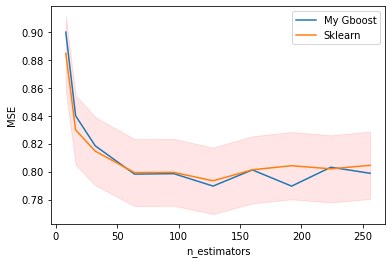

In [28]:
ci = np.multiply(loss, 0.03)

fig, ax = plt.subplots()
ax.plot(n_trees[:len(my_loss)], my_loss, label='My Gboost')
ax.plot(n_trees[:len(loss)], loss, label='Sklearn')

ax.fill_between(n_trees[:len(loss)], (loss-ci), (loss+ci), color='r', alpha=.1)
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.legend()

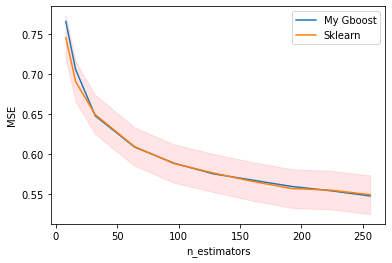

In [29]:
ci = np.multiply(loss, 0.03)

fig, ax = plt.subplots()
ax.plot(n_trees[:len(my_loss_train)], my_loss_train, label='My Gboost')
ax.plot(n_trees[:len(loss_train)], loss_train, label='Sklearn')

ax.fill_between(n_trees[:len(loss_train)], (loss_train-ci), (loss_train+ci), color='r', alpha=.1)
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.legend()

### LinReg over trees

In [61]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=32, learning_rate=0.1, max_depth=1, max_features=15, criterion='mse')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sklearn.metrics.mean_squared_error(y_pred, y_test)

0.8176607804361677

In [62]:
my_model = GradBoost(32, 0.1, max_depth=1, max_features=15)
my_model.fit(X_train, y_train)
y_pred = my_model.predict(X_test)
sklearn.metrics.mean_squared_error(y_test, y_pred)

0.831785967137727

In [63]:
lr = 0.1
def gen_features(X, models_list):
    To_regression = []
    
    Vec_preds = [model.predict(X) for model in models_list]
    
    for i, Sample in enumerate(X):
        Sample = Sample[np.newaxis, ...]
        vec_total = []
        for model_id in range(len(models_list)):
            vec = [0] * models_list[model_id].tree_.node_count
            num = models_list[model_id].apply(Sample)[0]
            #vec[num] = models_list[model_id].predict(Sample)[0]
            vec[num] = Vec_preds[model_id][i]
            vec_total += vec
        To_regression.append(vec_total)
    
    return np.array(To_regression)

In [64]:
my_reg_features_train = gen_features(X_train, my_model.boosted_models)
my_reg_features_test = gen_features(X_test, my_model.boosted_models)

In [65]:
reg_features_train = gen_features(X_train, [x[0] for x in model.estimators_])
reg_features_test = gen_features(X_test, [x[0] for x in model.estimators_])

In [66]:
my_model.predict(X_test)[0]

array([0.90643185])

In [67]:
my_reg_features_test[0].sum() * lr

0.9064318542418441

In [68]:
lin_reg = sklearn.linear_model.LinearRegression().fit(reg_features_train, y_train)
y_pred = lin_reg.predict(reg_features_test)

In [69]:
my_y_pred = my_reg_features_test @ scipy.linalg.lstsq(my_reg_features_train.astype('float64'), y_train.reshape(-1, 1).astype('float64'))[0]

In [72]:
sklearn.metrics.mean_squared_error(y_test, my_y_pred)

0.8262199254273997


In [73]:
sklearn.metrics.mean_squared_error(y_test, y_pred)

0.8068073455784003

### Last comparison (whole ensemble)

In [74]:
import tqdm

loss = []
my_loss = []

loss_train = []
my_loss_train = []

n_trees = [8, 16, 32, 64, 96, 128, 160, 192, 224, 256]

for n_estimators in tqdm.notebook.tqdm(n_trees):
    
    my_model = GradBoost(n_estimators, lr=0.1, max_depth=1, max_features=15)
    my_model.fit(X_train, y_train)
    
    my_reg_features_train = gen_features(X_train, my_model.boosted_models)
    my_reg_features_test = gen_features(X_test, my_model.boosted_models)
    
    model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=0.1, max_depth=1, max_features=15)
    model.fit(X_train, y_train)
    
    reg_features_train = gen_features(X_train, [x[0] for x in model.estimators_])
    reg_features_test = gen_features(X_test, [x[0] for x in model.estimators_])
    
    lin_reg = sklearn.linear_model.LinearRegression().fit(reg_features_train, y_train)
    
    y_pred = lin_reg.predict(reg_features_test)
    my_y_pred = my_reg_features_test @ scipy.linalg.lstsq(my_reg_features_train.astype('float64'), y_train.reshape(-1, 1).astype('float64'))[0]
    
    my_loss.append(sklearn.metrics.mean_squared_error(y_test, my_y_pred))
    loss.append(sklearn.metrics.mean_squared_error(y_test, y_pred))
    
    y_pred = lin_reg.predict(reg_features_train)
    loss_train.append(sklearn.metrics.mean_squared_error(y_train, y_pred))
    
    my_y_pred = my_reg_features_train @ scipy.linalg.lstsq(my_reg_features_train.astype('float64'), y_train.reshape(-1, 1).astype('float64'))[0]
    my_loss_train.append(sklearn.metrics.mean_squared_error(y_train, my_y_pred))

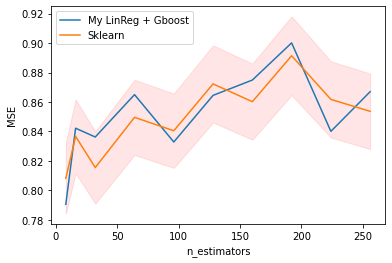

In [75]:
# Test
ci = np.multiply(loss, 0.03)

fig, ax = plt.subplots()
ax.plot(n_trees, my_loss, label='My LinReg + Gboost')
ax.plot(n_trees, loss, label='Sklearn')

ax.fill_between(n_trees, (loss-ci), (loss+ci), color='r', alpha=.1)
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.legend()

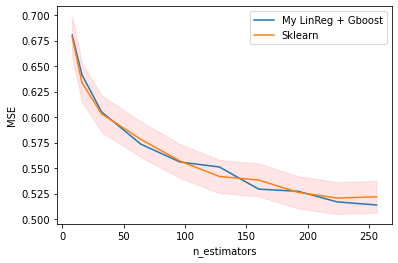

In [76]:
# Train
ci = np.multiply(loss_train, 0.03)

fig, ax = plt.subplots()
ax.plot(n_trees, my_loss_train, label='My LinReg + Gboost')
ax.plot(n_trees, loss_train, label='Sklearn')

ax.fill_between(n_trees, (loss_train-ci), (loss_train+ci), color='r', alpha=.1)
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.legend()

Регрессия сильно оверфитится?